#### Editing log:
##### Orignal from 09/18/2022
##### Edited in 02/15/2023
##### Edited in 03/01/2023
##### Edited in 03/02/2023
##### Edited in 03/29/2023

In [1]:
import pandas as pd
from sklearn import linear_model 
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,f1_score
#from sklearn.metrics import auc, confusion_matrix, f1_score, roc_auc_score, accuracy_score, recall_score
import pandas as pd
import numpy as np
from scipy.stats import stats
import os
import matplotlib.pyplot as plt
from random import choices
import xgboost as xgb
import xgboost as XGBClassifier

from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import GridSearchCV, train_test_split

from sklearn import metrics
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import auc, confusion_matrix, f1_score, roc_auc_score, accuracy_score, recall_score


In [3]:
# Define functions

def Filter_low_Expr(arr):
    total_len = len(arr)
    count = 0
    for i in arr:
        if i > 0:
            count = count + 1
    if count > 0.5*total_len: #If 
        return(True)
    else:
        return(False)
    
def formating_relative_expression(input_data,selected_genes_id, sele_house_keeping_id, KG_reg):
    array_list = []
    new_id_list = []
    for gene1 in selected_genes_id:

        for gene2 in sele_house_keeping_id:
            new_arr = (input_data.loc[[gene1],:].values - input_data.loc[[gene2],:].values)[0]
            new_arr_bi = []
            for i in new_arr:
                if i > 0:
                    new_arr_bi.append(1)
                else:
                    new_arr_bi.append(0)
            array_list.append(new_arr_bi)
            new_id_list.append(dic_gene_map[gene1] + '-' + dic_gene_map[gene2])

    for gene1 in selected_genes_id:
        cur_sele = KG_reg.loc[KG_reg['Target_gene'] == gene1]
        cur_regulators = list(cur_sele.loc[cur_sele['Coef'] < 0]['Regulator'])
        if gene1+"_intercept_" in cur_regulators:
            cur_regulators.remove(gene1+"_intercept_")
        #cur_regulators.remove(gene1+"_RSS")
        cur_regulators_ids = []
        for gene2 in cur_regulators:
            gene2 = dic_gene_map[gene2]
            #cur_regulators_ids.append(dic_gene_map[i])

            new_arr = (input_data.loc[[gene1],:].values - input_data.loc[[gene2],:].values)[0]
            new_arr_bi = []
            for i in new_arr:
                if i > 0:
                    new_arr_bi.append(1)
                else:
                    new_arr_bi.append(0)
            array_list.append(new_arr_bi)
            new_id_list.append(dic_gene_map[gene1] + '-' + dic_gene_map[gene2])

    new_feature_df = pd.DataFrame(array_list)
    new_feature_df.columns = input_data.columns
    new_feature_df.index = new_id_list
    new_feature_df_t = new_feature_df.transpose()
    return(new_feature_df_t)


def train_test_split_gq(df_sele, binary_cutoff, test_size):
    from sklearn.model_selection import train_test_split
    df_neg = df_sele.loc[df_sele['ic50'] > binary_cutoff]
    df_train_1, df_test_1 = train_test_split(df_neg, test_size = test_size)
    df_pos = df_sele.loc[df_sele['ic50'] <= binary_cutoff]
    df_train_2, df_test_2 = train_test_split(df_pos, test_size = test_size)
    
    df_train = pd.concat([df_train_1,df_train_2])
    df_test = pd.concat([df_test_1, df_test_2])
    
    return(df_train, df_test)

def model_run_with_Independent_testSet(train_data,test_data, train_labels, test_labels, independent_labels, independent_features): #modified at 11:46 AM Feb 15
    xgb_model = xgb.XGBClassifier(n_jobs=4)
    clf = GridSearchCV(xgb_model, {'max_depth': [2,3,4],
                                   'n_estimators': [100], 
                                   'learning_rate': [0.05, 0.1],
                                   #'gamma':[1],
                                   #'eta':[0.2,0.3,0.4],
                                  # 'min_child_weight':[1,2],
                                  # 'lambda':[1,2],
                                  # 'subsample':[0.8]
                                  }, verbose=1,cv=5, n_jobs=4) #5-fold cross validation

    clf.fit(train_data, train_labels.values)
    #print(clf.best_score_) #Train data
    para = (clf.best_params_)
    #print(clf.best_params_)

    xgb_model = xgb.XGBClassifier(n_jobs=1, learning_rate = para['learning_rate'], max_depth=para['max_depth'], n_estimators=para['n_estimators'])
    xgb_model.fit(train_data,train_labels.values)
    #predictions = xgb_model.predict(test_data)
    
    predictions = clf.predict(test_data)
    
    predictions_independent = clf.predict(independent_features)
    

    #print(pd.DataFrame({"Meausred": list(test_labels), "Predict": predictions}))

    # Evaluate the accuracy of the XGBoost model in the validation set (beatAML wave 1/2)
    accuracy = accuracy_score(test_labels, predictions)
    cm = confusion_matrix(  list(test_labels), predictions)
    tn = cm[0,0] #labled as negative and predicted as negative 
    fp = cm[0,1] #labeld as negative and predicted as positive
    fn = cm[1,0] #labeld as positive, and predicted as negative
    tp = cm[1,1] #labeld as positive, and predicted as positive
    
    sensitivity = cm[1,1]/(cm[1,0] + cm[1,1]) # TP/(FN + TP)
    specificity = tn/(tn+fp)
    
    precision = cm[1,1]/(cm[0,1] + cm[1,1])
    recall = recall_score(test_labels, predictions)
    blanced_acc = (sensitivity + specificity) /2 
    f1 = f1_score(list(test_labels), predictions)
    
    # Evaluate the accuracy of the XGBoost model in the testing set (beatAML wave 3/4)
    accuracy_independent = accuracy_score(independent_labels, predictions_independent)
    f1_independent = f1_score(independent_labels, predictions_independent)
    cm_independent = confusion_matrix(  list(independent_labels), predictions_independent)
    tn_independent = cm_independent[0,0] #labled as negative and predicted as negative 
    fp_independent = cm_independent[0,1] #labeld as negative and predicted as positive
    fn_independent = cm_independent[1,0] #labeld as positive, and predicted as negative
    tp_independent = cm_independent[1,1] #labeld as positive, and predicted as positive
    
    sensitivity_independent = cm_independent[1,1]/(cm_independent[1,0] + cm_independent[1,1]) # TP/(FN + TP)
    specificity_independent = tn_independent/(tn_independent+fp_independent)
    
    precision_independent = cm_independent[1,1]/(cm_independent[0,1] + cm_independent[1,1])
    recall_independent = recall_score(independent_labels, predictions_independent)
    blanced_acc_independent = (sensitivity_independent + specificity_independent) /2 
    recall_independent = recall_score(independent_labels, predictions_independent)
    # F1 = 2 x [(Precision x Recall) / (Precision + Recall)]

    #print("F1_score: " + str(f1))
    #print("# F1: 2 x [(Precision x Recall) / (Precision + Recall)]")

    result_feature = pd.DataFrame({"Feature":list(test_data.columns), "IMP":xgb_model.feature_importances_})
    result_feature= result_feature.loc[result_feature['IMP']>0].sort_values(by = ['IMP'], ascending = False)

    #features = ((list(result_feature.loc[result_feature['IMP']>0.05].sort_values(by = ["IMP"], ascending = False)['Feature'])))

    result_summary = {}
    result_summary['random_state'] = random_
    result_summary['best_params'] = clf.best_params_
    result_summary['Accuracy'] = accuracy #1
    result_summary['Precision'] = precision #2
    result_summary['sensitivity'] = sensitivity #3
    result_summary['F1_score'] = f1 #4
    result_summary['specificity'] = specificity #5
    result_summary['balanced_acc'] = blanced_acc #6
    result_summary['recall'] = recall #7
    
    
    result_summary['precision_independent'] = precision_independent #1
    result_summary['sensitivity_independent'] = sensitivity_independent #2
    result_summary['specificity_independent'] = specificity_independent #3
    result_summary['blanced_acc_independent'] = blanced_acc_independent #4
    result_summary['ACC_independent'] = accuracy_independent #5
    result_summary['F1_score_independent'] = f1_independent #6
    result_summary['recall_independent'] = recall_independent #7
    
    result_summary['features'] = result_feature
    return(result_summary)

In [4]:
# Load data
# Gene expression from BeatAML wave 1 and 2
Drug_data = pd.read_csv("../../../Data_resource/Drug_Response.csv",index_col = "Unnamed: 0") 
GE = pd.read_csv("../../../Data_resource/RPKM.csv",index_col = "Unnamed: 0")

#Load features from features that predict drug response, regulatory graph and house keeping genes
#sele_house_keeping =  ["GPS2", "RPS10","ZNF91","FNTA","PSMC1","GPS1","MLH1","ARAF","SF3B2","PSMD2","SRP14","GNB1","HNRNPK","ARF1","RPS11"]
sele_house_keeping = ['RPS10','FNTA','COX6A1','BECN1', 'SF3B2','PSMB2','AUP1','SRP14','HNRNPK', 'CCNI', 'RHOA', 'PABPC1','RPS11','TPT1','FTL']
KG_expr_resp = pd.read_csv("../../../../Manuscript/Supplemental_Tables/Supplemental_2_KG_Expr_drug_lasso_Coef_features_over0_gt50p.csv")
KG_reg = pd.read_csv("KG_regulatory_graph_Mar1_2023.csv")


# Load testing data from BeatAML wave 3 and 4
BeatAML_wave_3_expr = pd.read_csv("/Users/guangrong/Documents/Datasets/AML/BeatAML-wave1-4/Beat AML collaborator files Waves 1-4/rnaseq/beataml_waves1to4_allnorm.txt", sep = "\t") 
BeatAML_wave_3_drugResponse = pd.read_csv("/Users/guangrong/Documents/Datasets/AML/BeatAML-wave1-4/Beat AML collaborator files Waves 1-4/inhibitor/beataml_probit_curve_fits_v4_distr_nonproprietary.txt", sep = "\t")

In [17]:
len(set(Drug_data['inhibitor']))

122

In [5]:
#Formating gene expression data for testing data
BeatAML_wave_3_expr.index = BeatAML_wave_3_expr['stable_id']
gene_list = (list(BeatAML_wave_3_expr.index))
sample_list = list(set(BeatAML_wave_3_expr.columns) - set(['stable_id','display_label','description','biotype']))
input_data_test = BeatAML_wave_3_expr.loc[list(gene_list), sample_list]

#Formating gene expression data for training data
GE.index = GE['Gene']
gene_list = (list(GE.index))
sample_list = list(set(GE.columns) - set(['Gene','Symbol']))
input_data = GE.loc[list(gene_list), sample_list]

# Define gene_map
gene_map = GE.loc[:,['Gene','Symbol']]
dic_gene_map = {}
for i in range(0,gene_map.shape[0]):
    dic_gene_map[gene_map.iloc[i,0]] = gene_map.iloc[i,1]
    dic_gene_map[gene_map.iloc[i,1]] = gene_map.iloc[i,0]


In [25]:
# Feature selection: Selection of first neighbors
#Drug = "JQ1"
#Drug = "Trametinib (GSK1120212)"
Drug = "Selumetinib (AZD6244)"
#Drug = "Venetoclax"
#Drug = "Vandetanib (ZD6474)"
#Drug = "Idelalisib"
res1 = KG_expr_resp.loc[KG_expr_resp['Drug'] == Drug]
res1 = res1.sort_values(by = ['coef'])
predictors = list(res1['Gene'])
predictors.remove(Drug+"_RSS")
predictors.remove(Drug+"_intercept")

# Selection of the second neighbors
#res2 = KG_reg.loc[KG_reg['Target_gene'].isin( predictors[0:5] +  predictors[len(predictors)-5:len(predictors)])]
res2 = KG_reg.loc[KG_reg['Target_gene'].isin( predictors)]
res2 = res2.loc[res2['Coef'] <0]

selected_genes = list(KG_expr_resp.loc[KG_expr_resp['Drug'] == Drug]['Symbol'])
selected_genes.remove(Drug+"_RSS")
selected_genes.remove(Drug+"_intercept")
print(len(selected_genes))

60


44


In [26]:
print(selected_genes)

['MSR1', 'AACS', 'LGALS2', 'VTI1B', 'PCK2', 'CA2', 'FCER2', 'EPHB6', 'SLC35A3', 'SLC16A7', 'PAIP2', 'LRP1', 'SLC2A4RG', 'NRSN2', 'TNNI2', 'VEZF1', 'FAM129B', 'BAHD1', 'USP53', 'DCUN1D2', 'EPS8', 'DST', 'BANK1', 'EYA3', 'AUTS2', 'SIGLEC16', 'SYVN1', 'FABP5', 'DACT1', 'NDRG2', 'GNGT2', 'GTSF1', 'PKIA', 'GPHN', 'DPY19L3', 'TARSL2', 'CD300E', 'C22orf43', 'NTNG2', 'GAL3ST4', 'C1orf228', 'PTMAP3', 'RP6-206I17.1', 'RPL29P11', 'RP4-612B15.2', 'RPL7P11', 'LINC01071', 'RPL30P4', 'AMDP1', 'RP11-507E23.1', 'ETV5', 'RP11-506M13.3', 'CEBPA', 'CTD-2272G21.2', 'RP11-382J24.2', 'KIAA0754', 'EID3', 'RP11-1018J11.1', 'HMGB2P1', 'EEF1A1P7']


In [27]:
# Formating house keeping gene ids
sele_house_keeping_id = []
selected_genes_id = []

for g in selected_genes:
    selected_genes_id.append(dic_gene_map[g])
    
for g in sele_house_keeping:
    if g in dic_gene_map:
        sele_house_keeping_id.append(dic_gene_map[g])

In [28]:
new_feature_df_t = formating_relative_expression(input_data,selected_genes_id, sele_house_keeping_id, KG_reg)

new_feature_df_test = formating_relative_expression(input_data_test,selected_genes_id, sele_house_keeping_id, KG_reg)

In [11]:
# Select a subset of features for the modeling
#new_feature_df_t = new_feature_df_t[['FGD4-MIR4519','NPC2-GATA2']]
#new_feature_df_test = new_feature_df_test[['FGD4-MIR4519','NPC2-GATA2']]

In [29]:
# Formatting trainning data
Drug_sele_df = Drug_data.loc[Drug_data['inhibitor'] == Drug]
Drug_sele_df.index = Drug_sele_df['lab_id']
Drug_sele_df =Drug_sele_df.loc[:,['ic50']]

df_sele = pd.concat([new_feature_df_t, Drug_sele_df],axis = 1)
df_sele = df_sele.dropna()
df_sele.head(3)
df_sele.shape

(287, 1149)

In [379]:
# Formatting testing data using beatAML wave 3/4

In [30]:
Drug_sele_df_wave3 = BeatAML_wave_3_drugResponse.loc[BeatAML_wave_3_drugResponse['inhibitor'] == Drug]
Drug_sele_df_wave3.index = Drug_sele_df_wave3['lab_id']
Drug_sele_df_wave3 =Drug_sele_df_wave3.loc[:,['ic50']]

df_sele__wave3 = pd.concat([new_feature_df_test, Drug_sele_df_wave3],axis = 1)
df_sele__wave3 = df_sele__wave3.dropna()
df_sele__wave3.head(3)
df_sele__wave3.shape


(456, 1149)

In [31]:
df_sele__wave3_new = df_sele__wave3.loc[(set(df_sele__wave3.index)-set(df_sele.index)),:]

/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_62260/1949196757.py:1: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_sele__wave3_new = df_sele__wave3.loc[(set(df_sele__wave3.index)-set(df_sele.index)),:]


In [32]:
df_sele__wave3_new.shape

(169, 1149)

In [34]:
result_with_threshod = {}
#q10 =np.quantile(Drug_sele_df['ic50'].values, q = 0.25)
q25 =np.quantile(Drug_sele_df['ic50'].values, q = 0.25)
q50 = np.quantile(Drug_sele_df['ic50'].values, q = 0.5)
q75 = np.quantile(Drug_sele_df['ic50'].values, q = 0.75)

threshold_list_label = []
threshold_list = []
if q25 < 10:
    threshold_list.append(q25)
    threshold_list_label.append("Q25:" + str(round(q25,2)) + "μM")
if q50 < 10:
    threshold_list.append(q50)
    threshold_list_label.append("Q50:" + str(round(q50,2)) + "μM")
if q75 < 10:
    threshold_list.append(q75)
    threshold_list_label.append("Q75:" + str(round(q75,2)) + "μM")
#if q75 < 1:
#    threshold_list.append(1)

if max(threshold_list) < 1:
    threshold_list.append(1)
    threshold_list_label.append("1μM")
#if q75 < 1:
    
print(threshold_list)

[0.261748650043544, 1]


In [35]:
#Drug = "Venetoclax"

for Threshod in threshold_list:
    print(Threshod)
    data_cur = df_sele # Step 1
    data_cur = data_cur.dropna()
    new_label = []
    for i in data_cur['ic50'].values:
        if i <= Threshod:
            new_label.append(1)
        else:
            new_label.append(0)
    data_cur[Drug+"_bi"] = new_label
    
    df_sele__wave3_cur = df_sele__wave3_new
    new_label = []
    for i in df_sele__wave3_cur['ic50']:
        if i <= Threshod:
            new_label.append(1)
        else:
            new_label.append(0)
    df_sele__wave3_cur[Drug+"_bi"] = new_label

    result_all = {}
    result_all_test_w3 = {}
    for random_ in range(0,200,5): 
        sensitive_data = data_cur.loc[data_cur[Drug+"_bi"] == 1]
        resistant_data = data_cur.loc[data_cur[Drug+"_bi"] == 0]

        train_data_sen, test_data_sen, train_labels_sen, test_labels_sen = train_test_split(sensitive_data.iloc[:,:-2], 
                                                                            sensitive_data.iloc[:,-1],
                                                                            test_size = 0.2, random_state = random_)
        train_data_res, test_data_res, train_labels_res, test_labels_res = train_test_split(resistant_data.iloc[:,:-2], 
                                                                            resistant_data.iloc[:,-1],
                                                                            test_size = 0.2, random_state = random_)

        train_data = pd.concat([train_data_sen, train_data_res])
        test_data = pd.concat([test_data_sen, test_data_res])
        train_labels = pd.concat([train_labels_sen, train_labels_res])
        test_labels = pd.concat([test_labels_sen, test_labels_res])
        
        test_w3_labels = df_sele__wave3_cur[Drug+"_bi"]
        test_w3_features = df_sele__wave3_cur.iloc[:,:-2]
        
        result_all[random_] = model_run_with_Independent_testSet(train_data,test_data, train_labels, test_labels, df_sele__wave3_cur[Drug+"_bi"],  df_sele__wave3_cur.iloc[:,:-2])
        
    result_with_threshod[Threshod] = result_all


0.261748650043544
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for ea

In [38]:
print(df_sele__wave3_cur.shape)
print(train_data.shape)
print(test_data.shape)


(169, 1150)
(229, 1148)
(58, 1148)


In [39]:
max([1,2])

2

In [40]:
result_with_threshod

{0.261748650043544: {0: {'random_state': 0,
   'best_params': {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 100},
   'Accuracy': 0.7068965517241379,
   'Precision': 0.2727272727272727,
   'sensitivity': 0.25,
   'F1_score': 0.2608695652173913,
   'specificity': 0.8260869565217391,
   'balanced_acc': 0.5380434782608696,
   'recall': 0.25,
   'precision_independent': 0.7333333333333333,
   'sensitivity_independent': 0.38596491228070173,
   'specificity_independent': 0.9285714285714286,
   'blanced_acc_independent': 0.6572681704260652,
   'ACC_independent': 0.7455621301775148,
   'F1_score_independent': 0.5057471264367815,
   'recall_independent': 0.38596491228070173,
   'features':               Feature       IMP
   35       LGALS2-PSMB2  0.062281
   936      FCER2-BCL11A  0.055607
   1017    SIGLEC16-E2F1  0.032363
   604    C1orf228-SF3B2  0.030360
   542     CD300E-COX6A1  0.030326
   ...               ...       ...
   750        ETV5-RPS10  0.003598
   547      CD300E-SRP14 

In [41]:
Value_list = []
Type_list = []
Threshold_list = []
ACC_list = []
ACC_independent_test_list = []
F1_list = []
F1_independent_test_list = []

for Threshod in  result_with_threshod:
    for random_state in result_with_threshod[Threshod]:
        if "balanced_acc" in result_with_threshod[Threshod][random_state]:
            ACC_list.append(result_with_threshod[Threshod][random_state]['balanced_acc'])
        if "blanced_acc_independent" in result_with_threshod[Threshod][random_state]:
            ACC_independent_test_list.append(result_with_threshod[Threshod][random_state]['blanced_acc_independent'])
            
        if "F1_score" in result_with_threshod[Threshod][random_state]:
            F1_list.append(result_with_threshod[Threshod][random_state]['F1_score'])
        if "F1_score_independent" in result_with_threshod[Threshod][random_state]:
            F1_independent_test_list.append(result_with_threshod[Threshod][random_state]['F1_score_independent'])

        Threshold_list.append(Threshod)


threshold:0.261748650043544
W1/2:Balanced_ACC
0.5923913043478262
W3/4:Balanced_ACC
0.6201049498746867
threshold:1
W1/2:Balanced_ACC
0.6436011904761905
W3/4:Balanced_ACC
0.677405498281787


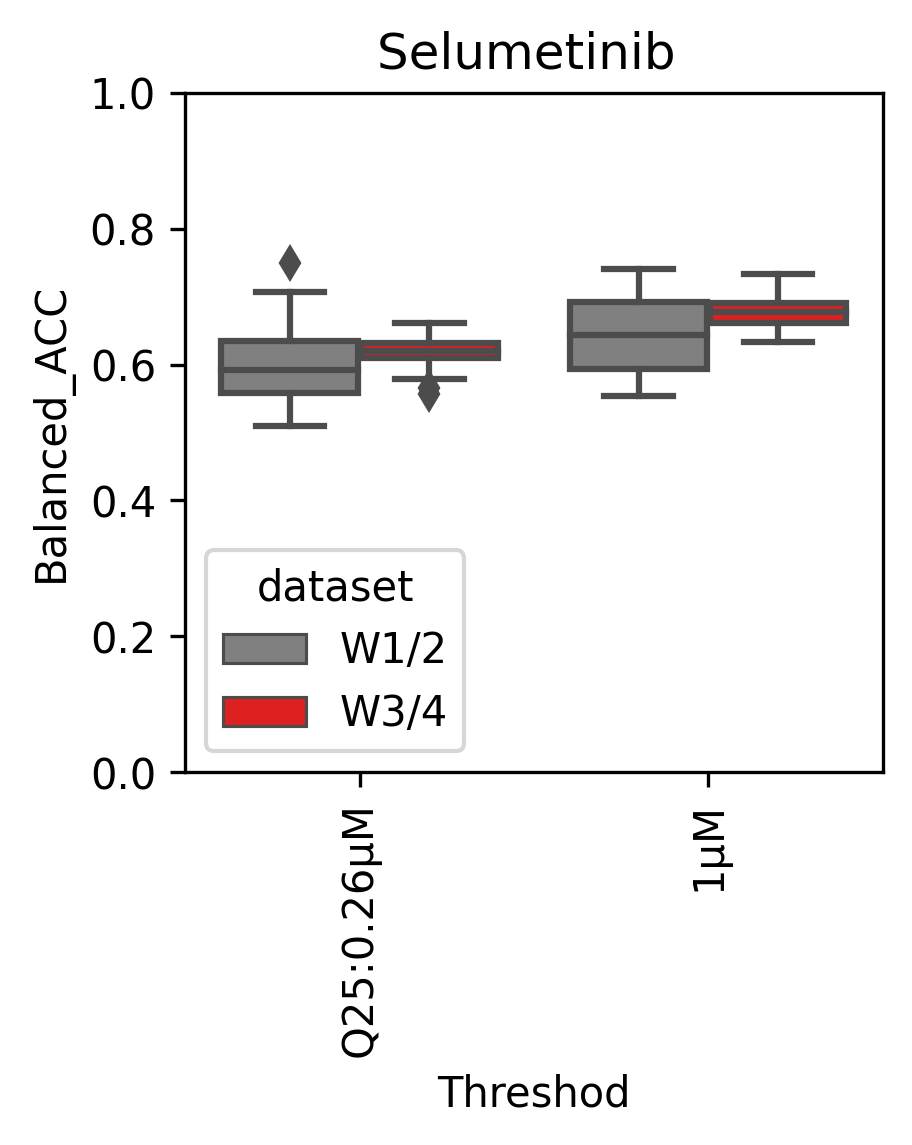

In [42]:
import seaborn as sns
plt.figure(figsize = (3,3),dpi = 300)
acc_df=pd.DataFrame({"Threshod":Threshold_list+Threshold_list, 
                     "Balanced_ACC":ACC_list+ACC_independent_test_list, 
                     "dataset":['W1/2']*len(Threshold_list) +['W3/4']*len(Threshold_list)})

sns.boxplot(x="Threshod", y="Balanced_ACC",
            hue="dataset", palette=["grey", "red"],
            data=acc_df)
plt.ylim(0,1)
plt.title(Drug.split("(")[0])
plt.xticks(range(0,len(threshold_list_label)), threshold_list_label, rotation = 90)

for threshold in set(Threshold_list):
    print("threshold:" + str(threshold))
    x = acc_df.loc[acc_df['Threshod'] == threshold]
    print("W1/2:Balanced_ACC")
    print(np.median(x.loc[x['dataset'] =='W1/2']['Balanced_ACC'].values))
    print("W3/4:Balanced_ACC")
    print(np.median(x.loc[x['dataset'] =='W3/4']['Balanced_ACC'].values))

    

threshold:0.261748650043544
W1/2:F1
0.3333333333333333
W3/4:F1
0.425
threshold:1
W1/2:F1
0.4747126436781609
W3/4:F1
0.5641025641025641


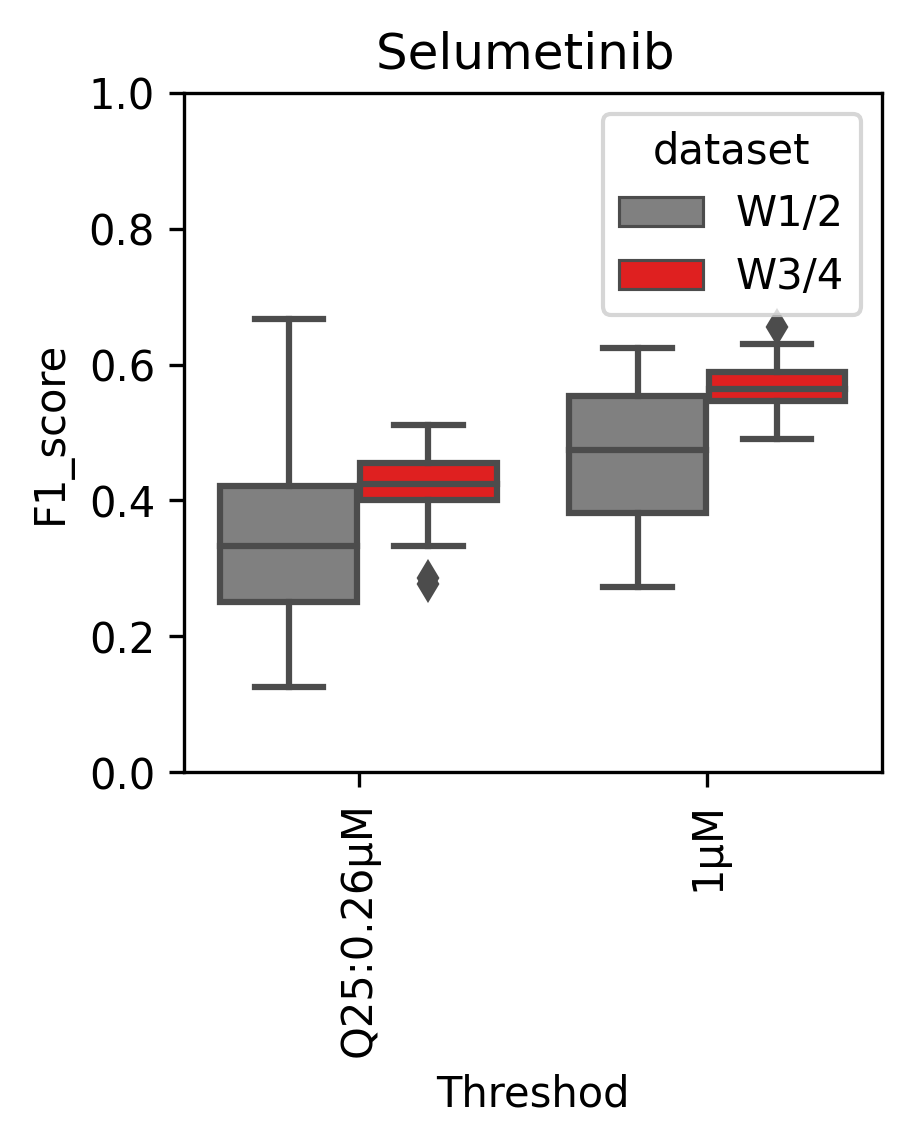

In [43]:
import seaborn as sns
plt.figure(figsize = (3,3),dpi = 300)
acc_df=pd.DataFrame({"Threshod":Threshold_list+Threshold_list, 
                     "F1_score":F1_list+F1_independent_test_list, 
                     "dataset":['W1/2']*len(Threshold_list) +['W3/4']*len(Threshold_list)})

sns.boxplot(x="Threshod", y="F1_score",
            hue="dataset", palette=["grey", "red"],
            data=acc_df)
plt.ylim(0,1)
plt.title(Drug.split("(")[0])
plt.xticks(range(0,len(threshold_list_label)), threshold_list_label, rotation = 90)

for threshold in set(Threshold_list):
    print("threshold:" + str(threshold))
    x = acc_df.loc[acc_df['Threshod'] == threshold]
    print("W1/2:F1")
    print(np.median(x.loc[x['dataset'] =='W1/2']['F1_score'].values))
    print("W3/4:F1")
    print(np.median(x.loc[x['dataset'] =='W3/4']['F1_score'].values))


In [45]:
feature_drug_df = pd.DataFrame()

sele_threshold = q25
for drug in [Drug]:
    test = result_with_threshod
    cur = test[sele_threshold]
    feature_df = pd.DataFrame()
    for random in cur:
        if cur[random]['Accuracy'] > 0.8 :
            feature_df_cur = cur[random]['features']
            feature_df_cur["IMP_"+str(random)]  = feature_df_cur['IMP']
            feature_df_cur.index = feature_df_cur['Feature']
            feature_df = pd.concat([feature_df, feature_df_cur["IMP_"+str(random)] ], axis =1)
    feature_df_sum = feature_df.sum(axis = 1)/feature_df.shape[1]
    result = pd.DataFrame({"features":feature_df_sum.index, 
                           "IMP":feature_df_sum.values, 
                           "Drug":[drug]*len(feature_df_sum.index)})
    
    feature_drug_df = pd.concat([feature_drug_df, result])

(178, 2)


([<matplotlib.axis.XTick at 0x14de82530>,
 [Text(0, 0, 'FCER2-BCL11A'),
  Text(1, 0, 'CD300E-COX6A1'),
  Text(2, 0, 'PKIA-MIR4461'),
  Text(3, 0, 'CA2-MIR5690'),
  Text(4, 0, 'FCER2-BECN1'),
  Text(5, 0, 'SIGLEC16-MIR643'),
  Text(6, 0, 'NTNG2-MIR647'),
  Text(7, 0, 'EPS8-ZEB1'),
  Text(8, 0, 'DACT1-MIR4461'),
  Text(9, 0, 'GAL3ST4-MIR940'),
  Text(10, 0, 'NTNG2-RPS10'),
  Text(11, 0, 'CA2-BECN1'),
  Text(12, 0, 'BANK1-RPS10'),
  Text(13, 0, 'DPY19L3-MIR3648'),
  Text(14, 0, 'LGALS2-SF3B2'),
  Text(15, 0, 'DCUN1D2-FNTA'),
  Text(16, 0, 'SLC16A7-FNTA'),
  Text(17, 0, 'SLC16A7-CEBPA'),
  Text(18, 0, 'RP11-506M13.3-MIR421'),
  Text(19, 0, 'LGALS2-ZNF317')])

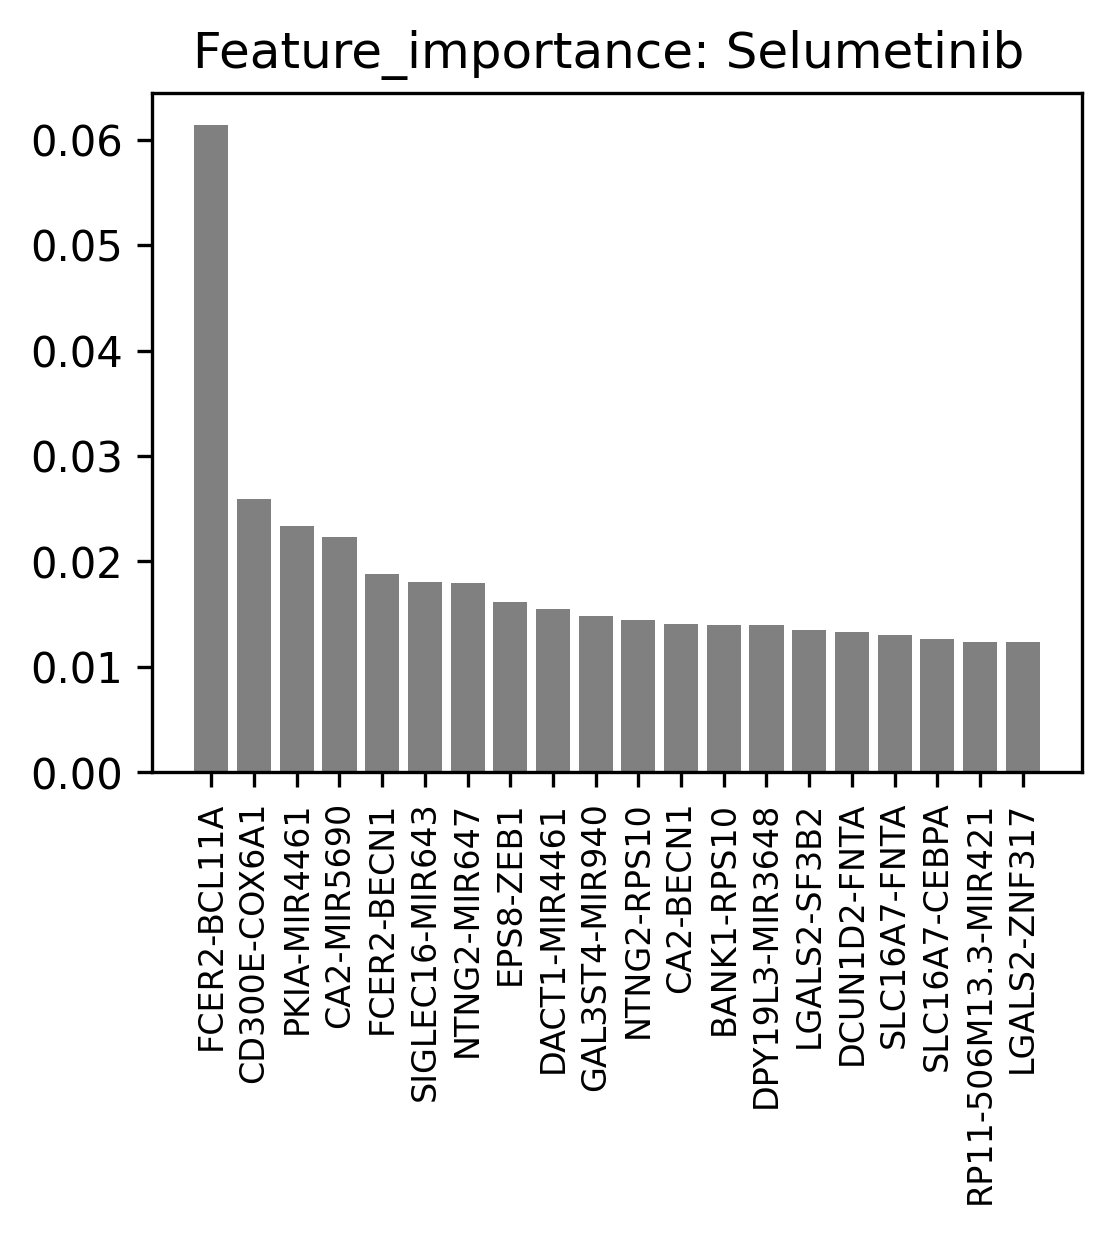

In [47]:
# Plot top important features 
feature_IMP =pd.DataFrame()
Threshold = q25
for random_state in result_with_threshod[Threshold]:
    if result_with_threshod[Threshold][random_state]['balanced_acc'] > 0.7:
        features = result_with_threshod[Threshold][random_state]['features']['Feature'].values
        IMP = result_with_threshod[Threshold][random_state]['features']['IMP'].values
        cur_df = pd.DataFrame({"IMP" + str(random_state): IMP})
        cur_df.index = features
        feature_IMP = pd.concat([feature_IMP,cur_df ],axis =1)
print(feature_IMP.shape)
IMP_sum = feature_IMP.transpose().sum()/feature_IMP.transpose().shape[0]
x_feature = pd.DataFrame({"Feature":IMP_sum.index, "IMP":IMP_sum.values})
x_feature_sorted = x_feature.sort_values(by = ["IMP"], ascending = False).head(20)

plt.figure(figsize = (4,3),dpi = 300)
plt.title("Feature_importance: " + Drug.split("(")[0])
plt.bar(np.arange(0,x_feature_sorted.shape[0], 1), x_feature_sorted['IMP'], width=0.8,  color = 'grey',
        bottom=None,  align='center')
#plt.ylabel("correlation coeffient")
plt.xticks(np.arange(0,x_feature_sorted.shape[0], 1),x_feature_sorted['Feature'] , rotation = 90, fontsize =8)



In [75]:
print(np.median(f1_df.loc[f1_df['Threshod(μM)'] == 1]['F1_score']))
print(np.median(acc_df.loc[acc_df['Threshod(μM)'] == 1]['ACC']))


0.8198949644732777
0.7704918032786885


In [311]:
result_with_threshod.keys()

dict_keys([0.0190925713799281, 1.45261900330956])